# Merging Prompt Results

In [ ]:
import pandas as pd

In [ ]:
label_dir = '/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/prompt_results'

In [ ]:
import os

os.listdir(label_dir)

['SAVE_gpt_3.5_survey_classification_with_direct_labels.json',
 'SAVE_gpt_3.5_survey_classification_with_desc.json',
 'SAVE_gpt_3.5_survey_classification_with_zero_shot_COT.json',
 'SAVE_gpt_3.5_survey_classification_with_tree_of_thoughts.json',
 'SAVE_gpt_3.5_survey_classification_with_steps_few_shot_COT.json',
 'SAVE_gpt_3.5_survey_classification_with_steps_few_shot_COT1.json',
 'SAVE_gpt_3.5_survey_classification_with_role.json',
 '.ipynb_checkpoints',
 'S_Gpt-3.5-turbo-desc_few_shot_prompt.json',
 'S_Gpt-3.5-turbo-desc_prompt.json',
 'S_Mistral-v2-instruct-desc_prompt.json',
 'S_Orca-instruct-desc_prompt.json',
 'SAVE_limitations_of_dissatisfied_Gpt3.5.json',
 'SAVE_limitations_of_dissatisfied_Gpt3.5_.json',
 'SAVE_advantages_of_dissatisfied_Gpt3.5_.json',
 'S_LlaMA-2-7b-chat-desc_prompt.json',
 'Orca-desc_prompt.json',
 'Orca-desc_prompt-fulldata.json']

In [ ]:
import os
import json

def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

files_in_label_dir = os.listdir(label_dir)

filtered_files = [filename for filename in files_in_label_dir if filename.startswith(('Orca-desc_prompt-fulldata.json'))]

data = {filename: load_json(os.path.join(label_dir, filename)) for filename in filtered_files}


In [ ]:
for filename, label_dict in data.items():
    print(filename, len(label_dict))

Orca-desc_prompt-fulldata.json 791


In [ ]:
import pandas as pd

def extract_comments(label_dict):
    return [label['comment'] for label in label_dict]

def match_and_indexify_comments_across_label_dicts(label_dicts):
    comments = set.union(*[set(extract_comments(label_dict)) for _, label_dict in label_dicts.items()])
    return {comment: i for i, comment in enumerate(comments)}

def convert_label_dict_to_df(name, label_dict, comment_to_index):
    df = pd.DataFrame(label_dict)
    df['comment_index'] = df['comment'].map(comment_to_index)
    df.drop('comment', axis=1, inplace=True)  # Drop the 'comment' column
    df.rename(columns={'list': name}, inplace=True)
    return df

def extract_name(filename):
    # SAVE_gpt_3.5_survey_classification_with_direct_labels.json
    return filename.split('Gpt-3.5')[1].split('.json')[0]

def convert_label_dicts_to_dfs(label_dicts, comment_to_index):
    return [convert_label_dict_to_df(extract_name(name), label_dict, comment_to_index) for name, label_dict in label_dicts.items()]

def merge_dfs(dfs):
    # Merge dataframes based on 'comment_index'
    merged_df = pd.concat([df.groupby('comment_index').agg('first') for df in dfs], axis=1, join='outer').reset_index()

    # Sort the dataframe based on 'comment_index'
    merged_df = merged_df.sort_values(by='comment_index')

    return merged_df

def merge_label_dicts(label_dicts):
    comment_to_index = match_and_indexify_comments_across_label_dicts(label_dicts)
    index_to_comment = {v: k for k, v in comment_to_index.items()}
    dfs = convert_label_dicts_to_dfs(label_dicts, comment_to_index)
    df = merge_dfs(dfs)
    df['comment'] = df['comment_index'].map(index_to_comment)
    return df

In [ ]:
df = merge_label_dicts(data)

In [ ]:

def read_and_convert_to_df(filename):
  data = load_json(os.path.join(label_dir, filename))
  df = pd.DataFrame(data)
  df = df[['comment', 'list']]
  return df

df = read_and_convert_to_df('Orca-desc_prompt-fulldata.json')


In [ ]:
df.head()

,comment,list
0,i haven’t used any of stony mental health reso...,\nMIXED
1,the fact that i know multiple people who were ...,\nMIXED
2,the student health center is easy to access. t...,\nMIXED
3,im really unfamiliar with the success of the s...,\nMIXED
4,there shouldn’t be a limit on the number of me...,\nMIXED


In [ ]:
# df = df.loc[:, ~df.columns.str.contains('prompt')]
df = df.drop('comment_index', axis=1)

In [ ]:
df.shape

(791, 2)

In [ ]:
df_merged.head()

,text,label
0,i haven’t used any of stony mental health reso...,not-satisfied
1,the fact that i know multiple people who were ...,not-satisfied
2,the student health center is easy to access. t...,both
3,im really unfamiliar with the success of the s...,neutral
4,there shouldn’t be a limit on the number of me...,not-satisfied


In [ ]:
# Ensure the column name is 'Comment' in data_df, it is case-sensitive
merged_df = pd.merge(df, df_merged[['text', 'label']], left_on='comment', right_on='text', how='inner')

# Drop the duplicate 'comment' column
merged_df.drop('text', axis=1, inplace=True)

In [ ]:
merged_df.head(5)

,comment,list,label
0,i haven’t used any of stony mental health reso...,\nMIXED,not-satisfied
1,the fact that i know multiple people who were ...,\nMIXED,not-satisfied
2,the student health center is easy to access. t...,\nMIXED,both
3,im really unfamiliar with the success of the s...,\nMIXED,neutral
4,there shouldn’t be a limit on the number of me...,\nMIXED,not-satisfied


In [ ]:
merged_df.shape

(791, 3)

In [ ]:
def get_last_10_words_reversed(sentence):
  words = sentence.split()
  if len(words) < 10:
    return []
  else:
    return words[-10:][::-1]

In [ ]:
import re
def extract_preprocessed_label(label):
  label = str(label)
  label = label.replace("\n", " ")
  label = re.sub(r'[^a-zA-Z0-9_ ]', '', label)
  if len(label.split(" ")) > 10:
    print(label)
    print("-------")
    words = get_last_10_words_reversed(label)
    words = [word for word in words]
    s = 0
    n = 0
    ns = 0
    if ("MIXED" in words) :
      print("MIXED")
      return "MIXED"
    elif ("NOT" in words) or ("DISSATISFIED" in words):
      print("DISSATISFIED")
      return "DISSATISFIED"
    elif ("SATISFIED" in words):
      print("SATISFIED")
      return "SATISFIED"
    elif ("NEUTRAL" in words):
      print("NEUTRAL")
      return "NEUTRAL"
  else:
    words = label.split(" ")[:10]
    words = [word.lower() for word in words]
    s = 0
    n = 0
    ns = 0
    if ("Mixed" in words) or ("mixed" in words) :
      return "MIXED"
    elif ("NOT" in words) or ("DISSATISFIED" in words) or ("dissatisfied" in words):
      return "DISSATISFIED"
    elif ("SATISFIED" in words) or ("satisfied" in words):
      return "SATISFIED"
    elif ("NEUTRAL" in words) or ("neutral" in words) or ("never" in words) :
      return "NEUTRAL"
    elif ("skip" in words) or ("SKIP" in words) or ("unrelated" in words):
      return "SKIP"


In [ ]:
new_df = merged_df.copy()

columns_to_double = ["list"]
new_df["new_list"] = new_df[columns_to_double].applymap(extract_preprocessed_label)

new_df

 Analysis The respondent mentions only one aspect that is working well which is the directions to the office The rest of the answer is dedicated to suggestions for improvement which is the aspect that may need more attention Therefore the answer is  DISSATISFIED
-------
DISSATISFIED
 Analysis The respondent mentions a success counselor who is good at recommending services and is open This part of the answer corresponds to the first part of the question which asks about aspects that are working well Therefore this part of the answer can be classified as SATISFIED  Final answer SATISFIED
-------
SATISFIED
 Analysis The respondent mentions that they tried to reach out to the campus mental health service online but they didnt get a reply This indicates dissatisfaction with the service The respondent also mentions that they tried to help themselves which implies that they are not satisfied with the service Therefore the answer is DISSATISFIED
-------
DISSATISFIED
 Analysis The respondent me

<ipython-input-72-1bd65acfa1cb>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df["new_list"] = new_df[columns_to_double].applymap(extract_preprocessed_label)


,comment,list,label,new_list
0,i haven’t used any of stony mental health reso...,\nMIXED,not-satisfied,MIXED
1,the fact that i know multiple people who were ...,\nMIXED,not-satisfied,MIXED
2,the student health center is easy to access. t...,\nMIXED,both,MIXED
3,im really unfamiliar with the success of the s...,\nMIXED,neutral,MIXED
4,there shouldn’t be a limit on the number of me...,\nMIXED,not-satisfied,MIXED
...,...,...,...,...
786,"uf has a “u matter we care” that works well, b...",\nMIXED,both,MIXED
787,"to be honest, they always say there are opport...",\nMIXED,not-satisfied,MIXED
788,i haven’t utilized on-campus services so i don...,\nNeutral,neutral,NEUTRAL
789,"caps work okay, but office hours or open hours...",\nMIXED,both,MIXED


In [ ]:
new_df[new_df["label"].isna()]

,comment,list,label,new_list


In [ ]:
new_df[new_df["new_list"] == "SKIP"]

,comment,list,label,new_list


In [ ]:
new_df[new_df["new_list"].isna()]

,comment,list,label,new_list
76,allow students to see their own counselors at ...,\nAnalysis:\nThe question asks for thoughts on...,not-satisfied,None
83,my experience with the colleges mental health ...,\nAnalysis:\n- The respondent starts by saying...,satisfied,None
140,"i have not used any programs, but i have notic...",\nAnalysis:\nThe respondent mentions that they...,both,None
159,caps does not really work and it somehow worse...,\nAnalysis:\nThe question has two parts: the f...,not-satisfied,None
235,the consistent emails let me know where i can ...,\nAnalysis:\nThe respondent mentions that the ...,satisfied,None
241,i am not sure. i don’t feel like i am getting ...,"\nAnalysis:\nThe respondent's answer is ""i am ...",not-satisfied,None
361,i think they are doing well about letting you ...,\nAnalysis:\nThe respondent mentions that the ...,satisfied,None
369,i think the triage needs more attention. it se...,\nAnalysis:\nThe respondent mentions two aspec...,both,None
376,there is a counselor and an online quiz thing....,\nWhat is your main reason for taking this sur...,neutral,None
459,i wouldn’t know given that i haven’t sought ou...,\nWhat is the respondent's answer to the quest...,neutral,None


In [ ]:
new_df.at[76, 'new_list'] = 'SATISFIED'
new_df.at[83, 'new_list'] = 'SATISFIED'
new_df.at[140, 'new_list'] = 'MIXED'
new_df.at[159, 'new_list'] = 'MIXED'
new_df.at[235, 'new_list'] = 'MIXED'
new_df.at[241, 'new_list'] = 'DISSATISFIED'
new_df.at[361, 'new_list'] = 'SATISFIED'
new_df.at[369, 'new_list'] = 'MIXED'
new_df.at[376, 'new_list'] = 'NEUTRAL'
new_df.at[459, 'new_list'] = 'NEUTRAL'
new_df.at[462, 'new_list'] = 'MIXED'
new_df.at[545, 'new_list'] = 'SATISFIED'
new_df.at[580, 'new_list'] = 'MIXED'
new_df.at[599, 'new_list'] = 'SATISFIED'
new_df.at[600, 'new_list'] = 'SATISFIED'
new_df.at[616, 'new_list'] = 'MIXED'
new_df.at[648, 'new_list'] = 'NEUTRAL'
new_df.at[653, 'new_list'] = 'MIXED'


In [ ]:
new_df.shape

(791, 4)

In [ ]:
new_df[new_df["new_list"].isna()]

,comment,list,label,new_list


In [ ]:
new_df['label'].value_counts()

,count
label,
not-satisfied,390
both,200
satisfied,105
neutral,96


In [ ]:
new_df[new_df["new_list"] == "SKIP"]

,comment,list,Validated_Labels,new_list


In [ ]:
new_df["label"].value_counts()

,count
label,
not-satisfied,390
both,200
satisfied,105
neutral,96


In [ ]:
mapping = {'SATISFIED': 1, 'DISSATISFIED': 3, 'NEUTRAL': 0, 'MIXED': 2, 'not-satisfied':3, 'satisfied':1, 'both':2, 'neutral':0}
new_df['new_list'] = new_df['new_list'].map(mapping)
new_df['label'] = new_df['label'].map(mapping)

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
report = classification_report(new_df['label'], new_df['new_list'] , labels=[0, 1, 2, 3])

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.93      0.14      0.24        96
           1       0.89      0.56      0.69       105
           2       0.32      0.97      0.48       200
           3       0.96      0.23      0.37       390

    accuracy                           0.45       791
   macro avg       0.77      0.48      0.44       791
weighted avg       0.78      0.45      0.42       791



In [ ]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 26})  # Increase font size here
    plt.xlabel('Predicted Label', fontsize=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=20, fontweight='bold')
    plt.xticks(fontsize=18)  # Increase x-axis tick label size and make bold
    plt.yticks(fontsize=18)  # Increase y-axis tick label size and make bold

    plt.show()

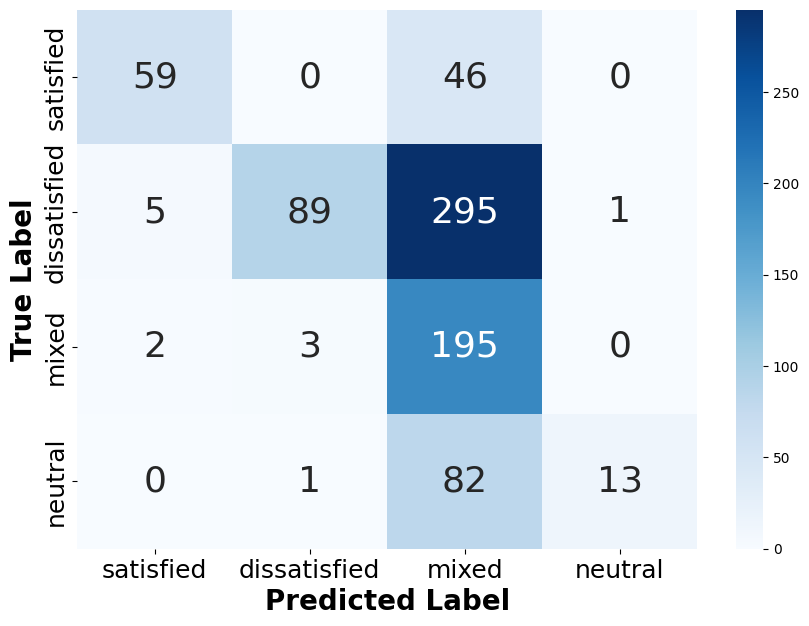

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(new_df['label'], new_df['new_list'], labels=[1, 3, 2, 0])
plot_confusion_matrix(cm, labels=['satisfied', 'dissatisfied', 'mixed', 'neutral'])

In [ ]:
new_df.to_csv('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/updated_results/results_with_labels_gpt-3.5-turbo-desc-prompt.csv', index=True)

# **Ensemble Methods for Classification**

In [ ]:
import pandas as pd
prompt_df = pd.read_csv('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/updated_results/updated_labels_with_gpt_3.5_results.csv')
prompt_df = prompt_df.drop('Unnamed: 0', axis=1)

In [ ]:
new_df.head()


,-turbo-desc_prompt,comment,Validated_Labels
0,DISSATISFIED,i think there needs to be an expansion. one qu...,not-satisfied
1,NEUTRAL,not too sure. don't have a ton of exposure to ...,neutral
2,DISSATISFIED,i have looked at group counseling but they are...,not-satisfied
3,DISSATISFIED,not much in my opinion i’d working well. i thi...,not-satisfied
4,SATISFIED,the group sessions for stress relief and medit...,both


In [ ]:
models = ["-turbo-desc_prompt"]

# Create a dictionary to store counts for each model
model_counts = {}

for model in models:
    counts = new_df[model].value_counts()
    model_counts[model] = counts

# Convert the dictionary to a DataFrame for better visualization
counts_df = pd.DataFrame(model_counts)

# Display the DataFrame
print(counts_df)

              -turbo-desc_prompt
MIXED                        302
DISSATISFIED                 278
NEUTRAL                      109
SATISFIED                    104


In [ ]:
# from sklearn.metrics import f1_score
# import pandas as pd

# prompts = ["MCQ", "summarization_MCQ", "fewshotMCQ", "summarization_fewshotMCQ", "explainedMCQ", "summarization_explainedMCQ"]

# label_mapping = {'SATISFIED': 1, 'DISSATISFIED': -1, 'NEUTRAL': 0, 'SKIP': -2, 'BOTH': 2, 'not-satisfied':-1, 'satisfied':1, 'neutral':0, 'skip':-2, 'both':2 }

# for prompt in prompts:
#     true_labels = prompt_df["Validated_Labels"].apply(lambda x: label_mapping.get(x, 0))
#     predicted_labels = prompt_df[prompt].apply(lambda x: label_mapping.get(x, 0))

#     f1 = f1_score(true_labels, predicted_labels, labels=[-1, 0, 1], average='weighted')
#     print(f"F1 score for {prompt}: {f1}")


from sklearn.metrics import f1_score
import pandas as pd

prompts = ["-turbo-desc_prompt"]

label_mapping = {'SATISFIED': 1, 'DISSATISFIED': -1, 'NEUTRAL': 0, 'SKIP': -2, 'BOTH': 2, 'MIXED':2, 'not-satisfied':-1, 'satisfied':1, 'neutral':0, 'skip':-2, 'both':2 }

for prompt in prompts:
    true_labels = new_df["Validated_Labels"].apply(lambda x: label_mapping.get(x, 0))
    predicted_labels = new_df[prompt].apply(lambda x: label_mapping.get(x, 0))

    f1 = f1_score(true_labels, predicted_labels, labels=[1, -1, 2, -2], average='weighted')
    print(f"F1 score for {prompt}: {f1}")


F1 score for -turbo-desc_prompt: 0.7372699803239372


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
# from sklearn.metrics import classification_report
# import pandas as pd
# from itertools import product

# prompts = ["MCQ", "summarization_MCQ", "fewshotMCQ", "summarization_fewshotMCQ", "explainedMCQ", "summarization_explainedMCQ"]

# label_mapping = {'SATISFIED': 1, 'DISSATISFIED': -1, 'NEUTRAL': 0, 'SKIP': -2, 'BOTH': 2, 'not-satisfied':-1, 'satisfied':1, 'neutral':0, 'skip':-2, 'both':2 }

# for prompt in prompts:
#     true_labels = prompt_df["Validated_Labels"].apply(lambda x: label_mapping.get(x, 0))
#     predicted_labels = prompt_df[prompt].apply(lambda x: label_mapping.get(x, 0))

#     # Get the classification report
#     report = classification_report(true_labels, predicted_labels, labels=[-1, 0, 1])
#     print(f"Classification report for {prompt}:\n{report}")
#     print("-----------------------------------------------")


from sklearn.metrics import classification_report
import pandas as pd
from itertools import product

prompts = ["-turbo-desc_prompt"]

label_mapping = {'SATISFIED': 1, 'DISSATISFIED': -1, 'NEUTRAL': -2, 'BOTH': 2, 'MIXED':2, 'not-satisfied':-1, 'satisfied':1, 'neutral':-2, 'both':2 }

for prompt in prompts:
    true_labels = new_df["Validated_Labels"].apply(lambda x: label_mapping.get(x, 0))
    predicted_labels = new_df[prompt].apply(lambda x: label_mapping.get(x, 0))

    # Get the classification report
    report = classification_report(true_labels, predicted_labels, labels=[1, -1, 2, -2])
    print(f"Classification report for {prompt}:\n{report}")
    print("-----------------------------------------------")


Classification report for -turbo-desc_prompt:
              precision    recall  f1-score   support

           1       0.72      0.71      0.71       106
          -1       0.94      0.66      0.78       392
           2       0.56      0.84      0.67       200
          -2       0.74      0.84      0.79        96

   micro avg       0.74      0.74      0.74       794
   macro avg       0.74      0.76      0.74       794
weighted avg       0.79      0.74      0.74       794

-----------------------------------------------


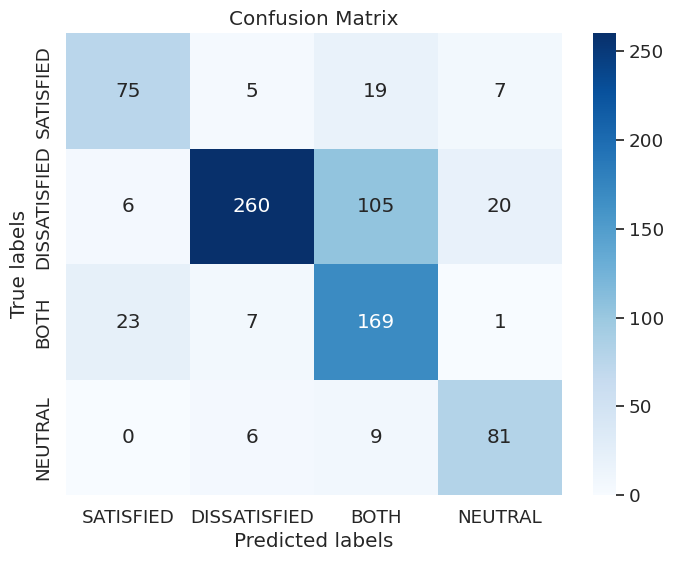

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

from sklearn.metrics import classification_report
import pandas as pd
from itertools import product

prompts = ["-turbo-desc_prompt"]

label_mapping = {'SATISFIED': 1, 'DISSATISFIED': -1, 'NEUTRAL': -2, 'BOTH': 2, 'MIXED':2, 'not-satisfied':-1, 'satisfied':1, 'neutral':-2, 'both':2 }

for prompt in prompts:
    true_labels = new_df["Validated_Labels"].apply(lambda x: label_mapping.get(x, 0))
    predicted_labels = new_df[prompt].apply(lambda x: label_mapping.get(x, 0))

    # Get the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=[1, -1, 2, -2])

    # Plot the confusion matrix
    plot_confusion_matrix(cm, labels=['SATISFIED', 'DISSATISFIED', 'BOTH', 'NEUTRAL'])

In [ ]:
new_df.to_csv('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/updated_results/compare_results_true_vs_gpt-3.5-turbo_desc.csv', index=True)

In [ ]:
# Assuming 'df' is your DataFrame

# List of models
all_models = ['gpt_3.5_turbo_instruct', 'orca_7b_8q', 'orca_7b_4q', 'llama2_7b_8q_chat', 'llama2_13b_4q_chat', 'mistral_instruct_7b_8q', 'falcon_7b_8q']

# Mapping function for labels
label_mapping = {'SATISFIED': 1, 'NOT_SATISFIED': -1, 'NEUTRAL': 0}

# Create a DataFrame to store F1 scores
# f1_scores_df = pd.DataFrame(columns=['True Model', 'Predicted Model', 'F1 Score'])

f1_scores = pd.DataFrame(index=all_models, columns=all_models)

convert = lambda x: label_mapping.get(x, 0)

for model_1 in all_models:
  for model_2 in all_models:
    true_labels = df[model_1].apply(convert)
    predicted_labels = df[model_2].apply(convert)

    f1 = f1_score(true_labels, predicted_labels, labels=[-1, 0, 1], average='weighted')
    # print(f"F1 score for {model}: {f1}")

    f1_scores.loc[model_1, model_2] = f1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

In [ ]:
display(f1_scores.T)

,gpt_3.5_turbo_instruct,orca_7b_8q,orca_7b_4q,llama2_7b_8q_chat,llama2_13b_4q_chat,mistral_instruct_7b_8q,falcon_7b_8q
gpt_3.5_turbo_instruct,1.0,0.723564,0.70376,0.664643,0.788424,0.808822,0.403929
orca_7b_8q,0.737975,1.0,0.829326,0.695728,0.698407,0.692589,0.565121
orca_7b_4q,0.714701,0.833751,1.0,0.70317,0.685194,0.675317,0.574561
llama2_7b_8q_chat,0.695357,0.719656,0.719907,1.0,0.766136,0.753926,0.416565
llama2_13b_4q_chat,0.690038,0.589286,0.577883,0.632326,1.0,0.896157,0.303979
mistral_instruct_7b_8q,0.689639,0.565872,0.54776,0.595304,0.882304,1.0,0.275862
falcon_7b_8q,0.102225,0.222571,0.231592,0.109589,0.054482,0.044138,1.0


In [ ]:
import pandas as pd

df['ensemble_prediction'] = df.apply(lambda row: max(set([row['orca_7b_8q'], row['mistral_instruct_7b_8q']])), axis=1)

print(df[['orca_7b_8q', 'mistral_instruct_7b_8q', 'ensemble_prediction']])

In [ ]:
path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/updated_results/compare_results_true_vs_gpt-3.5-turbo_desc.csv"

In [ ]:
import pandas as pd
temp_df = pd.read_csv(path)
temp_df = temp_df.drop('Unnamed: 0', axis=1)

In [ ]:
temp_df.head()

,comment,turbo-desc_prompt,Validated_Labels,Re - Validated Labels
0,i think there needs to be an expansion. one qu...,DISSATISFIED,not-satisfied,NaN
1,not too sure. don't have a ton of exposure to ...,NEUTRAL,neutral,NaN
2,i have looked at group counseling but they are...,DISSATISFIED,not-satisfied,NaN
3,not much in my opinion i’d working well. i thi...,DISSATISFIED,not-satisfied,NaN
4,the group sessions for stress relief and medit...,SATISFIED,both,SATISFIED


In [ ]:
import re
def extract_preprocessed_label(label):
  label = str(label)
  # label = re.sub(r'[^a-zA-Z0-9_ ]', '', label)
  words = label.split(" ")
  words = [word.lower() for word in words]
  s = 0
  n = 0
  ns = 0
  if ("both" in words) or ("mixed" in words) :
    return "MIXED"
  elif ("not-satisfied" in words) or ("DISSATISFIED" in words) or ("dissatisfied" in words):
    return "DISSATISFIED"
  elif ("SATISFIED" in words) or ("satisfied" in words):
    return "SATISFIED"
  elif ("NEUTRAL" in words) or ("neutral" in words) or ("never" in words) :
    return "NEUTRAL"
  elif ("skip" in words) or ("SKIP" in words) or ("unrelated" in words):
    return "SKIP"


In [ ]:
# Create a copy of the DataFrame
t_df = temp_df.copy()

# Select specific columns and apply the function to the new DataFrame
columns_to_double = ["Validated_Labels"]
t_df[columns_to_double] = t_df[columns_to_double].applymap(extract_preprocessed_label)

t_df

,comment,turbo-desc_prompt,Validated_Labels,Re - Validated Labels
0,i think there needs to be an expansion. one qu...,DISSATISFIED,DISSATISFIED,NaN
1,not too sure. don't have a ton of exposure to ...,NEUTRAL,NEUTRAL,NaN
2,i have looked at group counseling but they are...,DISSATISFIED,DISSATISFIED,NaN
3,not much in my opinion i’d working well. i thi...,DISSATISFIED,DISSATISFIED,NaN
4,the group sessions for stress relief and medit...,SATISFIED,MIXED,SATISFIED
...,...,...,...,...
789,my college works well in communicating about t...,MIXED,MIXED,NaN
790,"reaching out to the students, not a lot of peo...",DISSATISFIED,DISSATISFIED,NaN
791,having more sessions since it takes a while to...,MIXED,DISSATISFIED,DISSATISFIED
792,there are no resources (that i know of) to hel...,DISSATISFIED,DISSATISFIED,NaN


In [ ]:
def update_labels(row):
    if not pd.isnull(row["Re - Validated Labels"]):
        row["Validated_Labels"] = row["Re - Validated Labels"]
    return row

t_df = t_df.apply(update_labels, axis=1)
t_df.drop("Re - Validated Labels", axis=1, inplace=True)

In [ ]:
t_df

,comment,turbo-desc_prompt,Validated_Labels
0,i think there needs to be an expansion. one qu...,DISSATISFIED,DISSATISFIED
1,not too sure. don't have a ton of exposure to ...,NEUTRAL,NEUTRAL
2,i have looked at group counseling but they are...,DISSATISFIED,DISSATISFIED
3,not much in my opinion i’d working well. i thi...,DISSATISFIED,DISSATISFIED
4,the group sessions for stress relief and medit...,SATISFIED,SATISFIED
...,...,...,...
789,my college works well in communicating about t...,MIXED,MIXED
790,"reaching out to the students, not a lot of peo...",DISSATISFIED,DISSATISFIED
791,having more sessions since it takes a while to...,MIXED,DISSATISFIED
792,there are no resources (that i know of) to hel...,DISSATISFIED,DISSATISFIED


In [ ]:
t_df.to_csv('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/updated_results/updated_labels_with_gpt_3.5_results.csv', index=True)